# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from math import floor

import andes
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandapower as pp

from jams import rted2

from ev_ssm import ev_ssm

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.7.2.post257.dev0+ge3730f08
2.9.0


EV aggregator

`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [3]:
caseH = 10
sse = ev_ssm(ts=caseH, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")

EVA: ts=10[H], 10000 EVs, Total Q=250.12 MWh
Online 1983, Q=49.73 MWh, SoC=0.9834
Power(MW): Pt=-0.3613, Pc=-0.3613, Pd=-0.0
Ctrl: 0=1921; 1=62; 
EVA: Load A from Aest.csv.


Import ADNES case

In [4]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)
stg0idx = ssa.PV.idx.v + ssa.Slack.idx.v
pm0 = ssa.StaticGen.get(src='pmax', attr='v', idx=stg0idx)
ssa.StaticGen.set(src='pmax', attr='v', idx=stg0idx, value=2*pm0)

Working directory: "/home/jwang175/andes/jwang/notes2"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.2304 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0945 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0423 seconds.


True

Set output mode as 'manual', turn off TDS progress bar

In [5]:
ssa.TDS.config.save_mode = 'manual'
ssa.TDS.config.no_tqdm = 1

Set load as constant load.

In [6]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [7]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

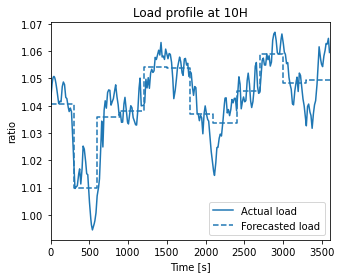

In [8]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/case/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

# the coefficient can be adjusted to fit the case
if caseH == 10:
    d_syn['sload'] = 0.8*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].min() + 1
if caseH == 18:
    d_syn['sload'] = 2*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].min() + 1

# extensify fluc
avg = d_syn['sload'].rolling(100).mean()
d_syn['sload'] = 1.5 * (d_syn['sload'] - avg) + avg
    
# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

# align starting point of load with starting point of dispatch results
d_syn['sload'][0] = d_exp['sload'].iloc[0]
d_syn['sload'][1:100] = None
d_syn['sload'] = d_syn['sload'].interpolate(method='polynomial', order=3)

# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['sload'], color='tab:blue', linestyle='-')
ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title(f'Load profile at {caseH}H')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [9]:
# --- set up EV generator data ---

ev_idx = 'PV_10'
ssa.PV.set(src='p0', idx=ev_idx, attr='v', value=sse.Ptc)
ssa.PV.set(src='pmax', idx=ev_idx, attr='v', value=sse.Pu)
ssa.PV.set(src='pmin', idx=ev_idx, attr='v', value=sse.Pl)

True

In [10]:
# --- convert to a pandapower instance ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, G1-11. G10 EV, G11 Slack
linearcost = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1, 1.5]

gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1024 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221393901e-09
Converged in 5 iterations in 0.0066 seconds.
Power flow results are consistent. Conversion is successful.


True

In [11]:
ssp.gen

,name,slack,bus,p_mw,vm_pu,controllable,in_service,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,slack_weight,scaling,sn_mva
0,PV_1,False,29,436.086385,1.035534,True,True,3000.0,200.0,183.816,-58.084,0.0,1,100
1,PV_2,False,30,645.999998,1.013246,True,True,1800.0,150.0,515.7648,-122.665,0.0,1,100
2,PV_3,False,31,724.999998,1.020528,True,True,1600.0,100.0,536.0664,-180.218,0.0,1,100
3,PV_4,False,32,651.999998,1.01343,True,True,1400.0,100.0,657.8496,-213.78,0.0,1,100
4,PV_5,False,33,520.0,1.019109,True,True,1400.0,100.0,733.794,-188.028,0.0,1,100
5,PV_6,False,34,690.0,1.06,True,True,1600.0,100.0,712.5456,-234.972,0.0,1,100
6,PV_7,False,35,590.0,1.06,True,True,1400.0,100.0,682.0464,-249.132,0.0,1,100
7,PV_8,False,36,330.0,1.013996,True,True,1400.0,100.0,532.1616,-216.122,0.0,1,100
8,PV_9,False,37,780.0,1.052803,True,True,2000.0,100.0,1001.73,-356.889,0.0,1,100
9,PV_10,False,37,-36.128532,1.052803,False,True,1144.862135,-38.104337,0.0,0.0,0.0,1,100


Set RTED instance ``ssd``

In [12]:
ssd = rted2()
ssd.from_andes(ssa)

# set EV generator as uncontrollable
ssd.gen.ctrl.iloc[9] = 0

# set EV geenrator as type2
prumax = sse.g_frc()[0]
prdmax = sse.g_frc()[1]
ssd.def_type2([ev_idx], [prumax], [prdmax])

# set ramp5
ramp_hour = [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999]
# ramp_hour = [80, 80, 80, 50, 50, 50, 30, 30, 30, 999, 30]
ssd.gen.ramp5 = np.array(ramp_hour) * 10 / 12 / ssd.mva

# set cost
ssd.cost.c1 = linearcost

# adjust SFR cost of EV lower than SynGen
ssd.cost.cru = 0.1
ev_loc = ssd.cost[ssd.cost.idx == ev_idx].index[0]
ssd.cost.cru.iloc[ev_loc] = 0.0999
ssd.cost.crd = ssd.cost.cru

# update p_pre from standard DCOPF results
ssd.set_p_pre()

# sovle the RTED
ssd.get_res()

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0079 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221393901e-09
Converged in 5 iterations in 0.0082 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xaa867f21
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xf213fb90
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [2e-02, 2e+03]
Presolve removed 117 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve RTED.


,gen,pg,pru,prd,bu,bd
0,PV_1,15.925285,0.0,0.0,0.0,0.0
1,PV_2,9.675000,0.0,0.0,0.0,0.0
2,PV_3,7.675000,0.0,0.0,0.0,0.0
3,PV_4,1.000000,0.0,0.0,0.0,0.0
4,PV_5,1.000000,0.0,0.0,0.0,0.0
5,PV_6,1.000000,0.0,0.0,0.0,0.0
6,PV_7,1.000000,0.0,0.0,0.0,0.0
7,PV_8,9.325000,0.0,0.0,0.0,0.0
8,PV_9,9.325000,0.0,0.0,0.0,0.0
9,PV_10,-0.361285,0.0,0.0,0.0,0.0


Benchmark ``ssd`` with ``ssp`` using standard DCOPF

In [13]:
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ssdc = ssd.to_dcopf()
gb_res = ssdc.get_res()
ppres['p_mw(GB)'] = ssp.sn_mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")
ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xaa867f21
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve DCOPF.


pp cost=6038.915679405395, gb cost=60.3891567865185


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,410.347230,92.622757,8.715538,1.0,1592.528532
1,560.494839,311.488301,8.413961,1.0,1800.000000
2,891.073553,149.407550,16.342173,1.0,1600.000000
3,557.166392,131.140357,12.880104,1.0,100.000000
4,557.207500,146.559740,12.798863,1.0,100.000000
5,482.830109,227.749422,13.919143,1.0,100.000000
6,671.394922,63.219181,20.746312,1.0,100.000000
7,331.934923,-27.585564,9.786085,1.0,100.000000
8,1130.079063,118.941642,28.419366,1.0,100.000000
9,-36.128532,0.000000,28.419366,1.0,-36.128532


## Prepare

### Make link table

In [14]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


### Define functions used in loop

In [15]:
# --- def. functions ---

def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed, ratio=0.1):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['sload'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = load_exp * ratio
    load_u = load_exp * ratio
    return load_u, load_d, load_exp

## Define param

In [16]:
# --- co-sim constants ---

rru = 1.0   # RegUp rate of EV
rrd = 0     # RegDn rate of EV
rsfr = 0.1  # ratio of SFR reserve out of total load

t_total = 3600    # total simulation time

# length of each interval
intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 50 # step change interval; smooth the setpoitns

# number of each interval
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssa_key2[['stg_idx', 'dg_idx', 'rg_idx', 'syg_idx', 
                      'exc_idx', 'gov_idx', 'gammap', 'ctrl']]
dcres = ssd.get_res()
agc_table = agc_table.merge(dcres[['gen', 'bu', 'bd']].rename(columns={'gen': 'stg_idx'}),
                            on='stg_idx', how='left')
agc_table['paux'] = 0

# AGC power of each unit
agc_in = pd.DataFrame(columns=['stg_idx'] + list(np.arange(0, t_total, 4)))
agc_in['stg_idx'] = agc_table['stg_idx']
agc_out = agc_in.copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.05
# SFR boundary and total AGC input
sfr_res = pd.DataFrame(columns=['cat'] + list(np.arange(0, t_total, 4)))
sfr_res['cat'] = ['time', 'ace', 'up', 'dn', 'in']

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

# EV results
ev_soc = pd.DataFrame(columns=range(t_total))
ev_agc = pd.DataFrame(columns=range(t_total))
ev_soc[0] = sse.ev.soc
ev_agc[0] = sse.ev.agc

# idx
ssp_res = runopp_map(ssp, ssa_key)

cond_sch_gov = ssp_res.controllable & ssp_res.gov_idx.fillna(False).astype(bool)
cond_sch_dg = ssp_res.controllable & ssp_res.dg_idx.fillna(False).astype(bool)
cond_agc_gov = agc_table.ctrl * agc_table.gov_idx.fillna(False).astype(bool)
cond_agc_dg = agc_table.ctrl * agc_table.dg_idx.fillna(False).astype(bool)

sch_gov_idx = ssp_res.gov_idx[cond_sch_gov].tolist()
sch_dg_idx = ssp_res.dg_idx[cond_sch_dg].tolist()
agc_gov_idx = agc_table.gov_idx[cond_agc_gov].tolist()
agc_dg_idx = agc_table.dg_idx[cond_agc_dg].tolist()


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xf213fb90
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [2e-02, 2e+03]
Presolve removed 117 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve RTED.


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

Check if RTED converge in all 12 intervals

In [17]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(t_total):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- update load ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed, rsfr)
        ssp.load.scaling = load_exp
        ssd.load['p0'] = ssa_p0 * load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        # initially set previous setpoints with standard DCOPF results
        # or set `pe` from TDS
        if end_time > 0:
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2, on='stg_idx',
                                  how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds
            ssd.gen.p_pre = pd.merge(left=ssd.gen, how='left', on='idx',
                                     right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
        else:
            ssd.set_p_pre()
            p_pre = ssd.gen[['idx', 'p_pre']].rename(columns={'p_pre': 'pe', 'idx': 'stg_idx'})

        # def. SFR requirements and calc. EV SFR capacities
        [prumax, prdmax] = sse.g_frc()
        # def. percentage of EV SFR capacities
        ssd.def_type2([ev_idx], [prumax*rru], [prdmax*rrd])
        ssd.def_sfr(du=du*ssa_p0_sum, dd=dd*ssa_p0_sum)

        # solve RTED
        dcres = ssd.get_res()

        # reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dcres.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=p_pre[['stg_idx', 'pe']],
                            on='stg_idx', how='left')['pe']
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen.ramp5))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen.ramp5))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)

        # --- ACOPF, modify setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis to normal limits
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- allocate AGC ---
        # assign participation factor `bu`, `bd`
        agc_table.drop(['bu', 'bd'], axis=1, inplace=True)
        agc_table = agc_table.merge(dcres[['gen', 'bu', 'bd']].rename(columns={'gen': 'stg_idx'}),
                                    on='stg_idx', how='left')
        # calc. AGC ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * agc_table['bu'] * agc_table['gammap']
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * agc_table['bd'] * agc_table['gammap']
        agc_in[end_time] = agc_table['paux']
        sfr_res[end_time] = [end_time, ACE_raw, dcres.pru.sum(),
                             -1*dcres.prd.sum(), ACE_input]

        # --- record AGC ---
        if end_time > 0:
            gref = ssa.TurbineGov.get(src='pref', attr='v', idx=agc_gov_idx)
            gout = ssa.TurbineGov.get(src='pout', attr='v', idx=agc_gov_idx)
            g_aux = gout - gref
            agc_out[end_time] = np.append(g_aux, [sse.Prc])

        # --- assign AGC ---
        # a.SynGen
        # Note: now the condition is controllable & has governor
        ssa.TurbineGov.set(src='paux0', idx=agc_gov_idx, attr='v',
                           value=agc_table.paux.values)
        # b.DG;
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                   value=agc_table.paux.values)
        # c.EV;
        # Note: EV is in group DG, remove EV set if not used for EV SSM
        sse_agc = agc_table[agc_table.stg_idx == ev_idx].paux.values
        # TODO: RenGen

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            if idx_agc == 0:
                # record `pe` from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.01
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # a.SynGen
            ssa.TurbineGov.set(src='pref0', idx=sch_gov_idx,
                               attr='v', value=ssp_res.pref[cond_sch_gov].values)
            # b.DG
            ssa.DG.set(src='pref0', idx=sch_dg_idx,
                       attr='v', value=ssp_res.pref[cond_sch_dg].values)

    # --- intv_pq: alter load, run TDS ---
    # Initially, alter StaticGen: p0 and q0, run PFlow
    # Otherwise, alter Ppf and Qpf
    if end_time == 0:
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.StaticGen.set(src='v0', idx=stg_opf_idx, attr='v', value=stg_opf_v)
        # initial load point set as the dispatch point
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * load_exp)
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * load_exp)
        ssa.PFlow.run()
    else:
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['sload'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['sload'].iloc[end_time])
        # run `sse`
        sse.run(tf=caseH+end_time/3600, Pi=sse_agc[0],
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
        ev_soc[end_time] = sse.ev.soc
        ev_agc[end_time] = sse.ev.agc
        sse.report(is_report=False)
        ssa.EV2.set(src='pref0', idx=ssp_res.dg_idx[ssp_res.stg_idx == ev_idx].values[0],
                   attr='v', value=sse.Ptc)

    # run TDS
    ssa.TDS.config.tf = end_time
    if end_time == 0:
        ssa.TDS.init()
    ssa.TDS.run()
    # update AGC PI Controller
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xd9e0d67f
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2895318e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.289531792e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x45cddc7e
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 107 rows and 15 columns
Presolve time: 0.01s
Presolved: 10 rows, 18 columns, 34 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4116110e+01   2.081250e+00   0.000000e+00      0s
       1    6.4116110e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.411611044e+01


Successfully solve RTED.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0083 seconds.
0: |F(x)| = 7.943401128
1: |F(x)| = 3.637879139
2: |F(x)| = 0.2091774587
3: |F(x)| = 0.0009931255499
4: |F(x)| = 4.1633343e-08
Converged in 5 iterations in 0.0079 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for dynamics completed in 0.3095 seconds.
Initialization was successful.

-> Ti

Simulation to t=125.00 sec completed in 0.0664 seconds.
Simulation to t=126.00 sec completed in 0.0663 seconds.
Simulation to t=127.00 sec completed in 0.0664 seconds.
Simulation to t=128.00 sec completed in 0.0666 seconds.
Simulation to t=129.00 sec completed in 0.0666 seconds.
Simulation to t=130.00 sec completed in 0.0667 seconds.
Simulation to t=131.00 sec completed in 0.0665 seconds.
Simulation to t=132.00 sec completed in 0.0664 seconds.
Simulation to t=133.00 sec completed in 0.0664 seconds.
Simulation to t=134.00 sec completed in 0.0663 seconds.
Simulation to t=135.00 sec completed in 0.0672 seconds.
Simulation to t=136.00 sec completed in 0.0664 seconds.
Simulation to t=137.00 sec completed in 0.0663 seconds.
Simulation to t=138.00 sec completed in 0.0659 seconds.
Simulation to t=139.00 sec completed in 0.0658 seconds.
Simulation to t=140.00 sec completed in 0.0691 seconds.
Simulation to t=141.00 sec completed in 0.0668 seconds.
Simulation to t=142.00 sec completed in 0.0662 s

Simulation to t=272.00 sec completed in 0.0665 seconds.
Simulation to t=273.00 sec completed in 0.0667 seconds.
Simulation to t=274.00 sec completed in 0.0661 seconds.
Simulation to t=275.00 sec completed in 0.0656 seconds.
Simulation to t=276.00 sec completed in 0.0853 seconds.
Simulation to t=277.00 sec completed in 0.0655 seconds.
Simulation to t=278.00 sec completed in 0.0824 seconds.
Simulation to t=279.00 sec completed in 0.0656 seconds.
Simulation to t=280.00 sec completed in 0.0884 seconds.
Simulation to t=281.00 sec completed in 0.0687 seconds.
Simulation to t=282.00 sec completed in 0.0863 seconds.
Simulation to t=283.00 sec completed in 0.0708 seconds.
Simulation to t=284.00 sec completed in 0.0902 seconds.
Simulation to t=285.00 sec completed in 0.0815 seconds.
Simulation to t=286.00 sec completed in 0.0884 seconds.
Simulation to t=287.00 sec completed in 0.0814 seconds.
Simulation to t=288.00 sec completed in 0.0946 seconds.
Simulation to t=289.00 sec completed in 0.0904 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xb73f5de9
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.01s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4676628e+01   7.493948e+01   0.000000e+00      0s
       2    6.2146368e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.214636792e+01


Successfully solve RTED.
Simulation to t=300.00 sec completed in 0.1075 seconds.
Simulation to t=301.00 sec completed in 0.1274 seconds.
Simulation to t=302.00 sec completed in 0.1257 seconds.
Simulation to t=303.00 sec completed in 0.1335 seconds.
Simulation to t=304.00 sec completed in 0.1303 seconds.
Simulation to t=305.00 sec completed in 0.1575 seconds.
Simulation to t=306.00 sec completed in 0.1546 seconds.
Simulation to t=307.00 sec completed in 0.1531 seconds.
Simulation to t=308.00 sec completed in 0.1069 seconds.
Simulation to t=309.00 sec completed in 0.1179 seconds.
Simulation to t=310.00 sec completed in 0.1235 seconds.
Simulation to t=311.00 sec completed in 0.1105 seconds.
Simulation to t=312.00 sec completed in 0.1216 seconds.
Simulation to t=313.00 sec completed in 0.1236 seconds.
Simulation to t=314.00 sec completed in 0.1235 seconds.
Simulation to t=315.00 sec completed in 0.1240 seconds.
Simulation to t=316.00 sec completed in 0.1261 seconds.
Simulation to t=317.00 

Simulation to t=446.00 sec completed in 0.0683 seconds.
Simulation to t=447.00 sec completed in 0.0649 seconds.
Simulation to t=448.00 sec completed in 0.0794 seconds.
Simulation to t=449.00 sec completed in 0.0655 seconds.
Simulation to t=450.00 sec completed in 0.0655 seconds.
Simulation to t=451.00 sec completed in 0.0658 seconds.
Simulation to t=452.00 sec completed in 0.0764 seconds.
Simulation to t=453.00 sec completed in 0.0646 seconds.
Simulation to t=454.00 sec completed in 0.0700 seconds.
Simulation to t=455.00 sec completed in 0.0667 seconds.
Simulation to t=456.00 sec completed in 0.0889 seconds.
Simulation to t=457.00 sec completed in 0.0799 seconds.
Simulation to t=458.00 sec completed in 0.0826 seconds.
Simulation to t=459.00 sec completed in 0.0697 seconds.
Simulation to t=460.00 sec completed in 0.0930 seconds.
Simulation to t=461.00 sec completed in 0.0870 seconds.
Simulation to t=462.00 sec completed in 0.0930 seconds.
Simulation to t=463.00 sec completed in 0.0795 s

Simulation to t=593.00 sec completed in 0.0705 seconds.
Simulation to t=594.00 sec completed in 0.0723 seconds.
Simulation to t=595.00 sec completed in 0.0695 seconds.
Simulation to t=596.00 sec completed in 0.0884 seconds.
Simulation to t=597.00 sec completed in 0.0724 seconds.
Simulation to t=598.00 sec completed in 0.0724 seconds.
Simulation to t=599.00 sec completed in 0.0704 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xb8e1fd9d
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [2e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7886436e+01   7.163210e+01   0.000000e+00      0s
       2    6.3702485e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.370248482e+01


Successfully solve RTED.
Simulation to t=600.00 sec completed in 0.0958 seconds.
Simulation to t=601.00 sec completed in 0.0737 seconds.
Simulation to t=602.00 sec completed in 0.0705 seconds.
Simulation to t=603.00 sec completed in 0.0696 seconds.
Simulation to t=604.00 sec completed in 0.0902 seconds.
Simulation to t=605.00 sec completed in 0.0959 seconds.
Simulation to t=606.00 sec completed in 0.1005 seconds.
Simulation to t=607.00 sec completed in 0.0984 seconds.
Simulation to t=608.00 sec completed in 0.0677 seconds.
Simulation to t=609.00 sec completed in 0.0685 seconds.
Simulation to t=610.00 sec completed in 0.0685 seconds.
Simulation to t=611.00 sec completed in 0.0686 seconds.
Simulation to t=612.00 sec completed in 0.0908 seconds.
Simulation to t=613.00 sec completed in 0.0923 seconds.
Simulation to t=614.00 sec completed in 0.0809 seconds.
Simulation to t=615.00 sec completed in 0.0664 seconds.
Simulation to t=616.00 sec completed in 0.0673 seconds.
Simulation to t=617.00 

Simulation to t=746.00 sec completed in 0.0680 seconds.
Simulation to t=747.00 sec completed in 0.0679 seconds.
Simulation to t=748.00 sec completed in 0.0710 seconds.
Simulation to t=749.00 sec completed in 0.0682 seconds.
Simulation to t=750.00 sec completed in 0.0732 seconds.
Simulation to t=751.00 sec completed in 0.0758 seconds.
Simulation to t=752.00 sec completed in 0.0681 seconds.
Simulation to t=753.00 sec completed in 0.0671 seconds.
Simulation to t=754.00 sec completed in 0.0675 seconds.
Simulation to t=755.00 sec completed in 0.0678 seconds.
Simulation to t=756.00 sec completed in 0.0697 seconds.
Simulation to t=757.00 sec completed in 0.0676 seconds.
Simulation to t=758.00 sec completed in 0.0670 seconds.
Simulation to t=759.00 sec completed in 0.0670 seconds.
Simulation to t=760.00 sec completed in 0.0699 seconds.
Simulation to t=761.00 sec completed in 0.0688 seconds.
Simulation to t=762.00 sec completed in 0.0675 seconds.
Simulation to t=763.00 sec completed in 0.0666 s

Simulation to t=893.00 sec completed in 0.0684 seconds.
Simulation to t=894.00 sec completed in 0.0683 seconds.
Simulation to t=895.00 sec completed in 0.0684 seconds.
Simulation to t=896.00 sec completed in 0.0693 seconds.
Simulation to t=897.00 sec completed in 0.0684 seconds.
Simulation to t=898.00 sec completed in 0.0698 seconds.
Simulation to t=899.00 sec completed in 0.0734 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x0c41550d
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6925574e+01   7.382167e+01   0.000000e+00      0s
       2    6.3836409e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.383640944e+01


Successfully solve RTED.
Simulation to t=900.00 sec completed in 0.0694 seconds.
Simulation to t=901.00 sec completed in 0.0685 seconds.
Simulation to t=902.00 sec completed in 0.0688 seconds.
Simulation to t=903.00 sec completed in 0.0675 seconds.
Simulation to t=904.00 sec completed in 0.0686 seconds.
Simulation to t=905.00 sec completed in 0.0678 seconds.
Simulation to t=906.00 sec completed in 0.0677 seconds.
Simulation to t=907.00 sec completed in 0.0701 seconds.
Simulation to t=908.00 sec completed in 0.0688 seconds.
Simulation to t=909.00 sec completed in 0.0752 seconds.
Simulation to t=910.00 sec completed in 0.0679 seconds.
Simulation to t=911.00 sec completed in 0.0698 seconds.
Simulation to t=912.00 sec completed in 0.0807 seconds.
Simulation to t=913.00 sec completed in 0.0892 seconds.
Simulation to t=914.00 sec completed in 0.0885 seconds.
Simulation to t=915.00 sec completed in 0.0789 seconds.
Simulation to t=916.00 sec completed in 0.0697 seconds.
Simulation to t=917.00 

Simulation to t=1046.00 sec completed in 0.0742 seconds.
Simulation to t=1047.00 sec completed in 0.0855 seconds.
Simulation to t=1048.00 sec completed in 0.0726 seconds.
Simulation to t=1049.00 sec completed in 0.0676 seconds.
Simulation to t=1050.00 sec completed in 0.0673 seconds.
Simulation to t=1051.00 sec completed in 0.0684 seconds.
Simulation to t=1052.00 sec completed in 0.0681 seconds.
Simulation to t=1053.00 sec completed in 0.0680 seconds.
Simulation to t=1054.00 sec completed in 0.0679 seconds.
Simulation to t=1055.00 sec completed in 0.0800 seconds.
Simulation to t=1056.00 sec completed in 0.0682 seconds.
Simulation to t=1057.00 sec completed in 0.0751 seconds.
Simulation to t=1058.00 sec completed in 0.0680 seconds.
Simulation to t=1059.00 sec completed in 0.0686 seconds.
Simulation to t=1060.00 sec completed in 0.0721 seconds.
Simulation to t=1061.00 sec completed in 0.0692 seconds.
Simulation to t=1062.00 sec completed in 0.0696 seconds.
Simulation to t=1063.00 sec com

Simulation to t=1190.00 sec completed in 0.0752 seconds.
Simulation to t=1191.00 sec completed in 0.0685 seconds.
Simulation to t=1192.00 sec completed in 0.0709 seconds.
Simulation to t=1193.00 sec completed in 0.0680 seconds.
Simulation to t=1194.00 sec completed in 0.0674 seconds.
Simulation to t=1195.00 sec completed in 0.0683 seconds.
Simulation to t=1196.00 sec completed in 0.0679 seconds.
Simulation to t=1197.00 sec completed in 0.0675 seconds.
Simulation to t=1198.00 sec completed in 0.0677 seconds.
Simulation to t=1199.00 sec completed in 0.0676 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xf4ea68c2
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.01s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8296608e+01   7.298898e+01   0.000000e+00      0s
       2    6.4791097e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.479109664e+01


Successfully solve RTED.
Simulation to t=1200.00 sec completed in 0.1061 seconds.
Simulation to t=1201.00 sec completed in 0.0831 seconds.
Simulation to t=1202.00 sec completed in 0.0752 seconds.
Simulation to t=1203.00 sec completed in 0.0675 seconds.
Simulation to t=1204.00 sec completed in 0.0736 seconds.
Simulation to t=1205.00 sec completed in 0.0827 seconds.
Simulation to t=1206.00 sec completed in 0.0836 seconds.
Simulation to t=1207.00 sec completed in 0.0695 seconds.
Simulation to t=1208.00 sec completed in 0.1017 seconds.
Simulation to t=1209.00 sec completed in 0.0881 seconds.
Simulation to t=1210.00 sec completed in 0.0868 seconds.
Simulation to t=1211.00 sec completed in 0.0677 seconds.
Simulation to t=1212.00 sec completed in 0.0688 seconds.
Simulation to t=1213.00 sec completed in 0.0687 seconds.
Simulation to t=1214.00 sec completed in 0.0740 seconds.
Simulation to t=1215.00 sec completed in 0.0689 seconds.
Simulation to t=1216.00 sec completed in 0.0873 seconds.
Simula

Simulation to t=1344.00 sec completed in 0.0833 seconds.
Simulation to t=1345.00 sec completed in 0.0887 seconds.
Simulation to t=1346.00 sec completed in 0.0731 seconds.
Simulation to t=1347.00 sec completed in 0.0707 seconds.
Simulation to t=1348.00 sec completed in 0.0846 seconds.
Simulation to t=1349.00 sec completed in 0.0715 seconds.
Simulation to t=1350.00 sec completed in 0.0700 seconds.
Simulation to t=1351.00 sec completed in 0.0683 seconds.
Simulation to t=1352.00 sec completed in 0.0864 seconds.
Simulation to t=1353.00 sec completed in 0.0814 seconds.
Simulation to t=1354.00 sec completed in 0.0727 seconds.
Simulation to t=1355.00 sec completed in 0.0686 seconds.
Simulation to t=1356.00 sec completed in 0.0680 seconds.
Simulation to t=1357.00 sec completed in 0.0686 seconds.
Simulation to t=1358.00 sec completed in 0.0680 seconds.
Simulation to t=1359.00 sec completed in 0.0682 seconds.
Simulation to t=1360.00 sec completed in 0.0714 seconds.
Simulation to t=1361.00 sec com

Simulation to t=1488.00 sec completed in 0.0690 seconds.
Simulation to t=1489.00 sec completed in 0.0690 seconds.
Simulation to t=1490.00 sec completed in 0.0692 seconds.
Simulation to t=1491.00 sec completed in 0.0687 seconds.
Simulation to t=1492.00 sec completed in 0.0683 seconds.
Simulation to t=1493.00 sec completed in 0.0705 seconds.
Simulation to t=1494.00 sec completed in 0.0691 seconds.
Simulation to t=1495.00 sec completed in 0.0697 seconds.
Simulation to t=1496.00 sec completed in 0.0686 seconds.
Simulation to t=1497.00 sec completed in 0.0742 seconds.
Simulation to t=1498.00 sec completed in 0.0742 seconds.
Simulation to t=1499.00 sec completed in 0.0750 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x9a894f1d
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8533141e+01   7.247930e+01   0.000000e+00      0s
       2    6.4772790e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.477278977e+01


Successfully solve RTED.
Simulation to t=1500.00 sec completed in 0.0754 seconds.
Simulation to t=1501.00 sec completed in 0.0787 seconds.
Simulation to t=1502.00 sec completed in 0.0877 seconds.
Simulation to t=1503.00 sec completed in 0.0743 seconds.
Simulation to t=1504.00 sec completed in 0.0895 seconds.
Simulation to t=1505.00 sec completed in 0.0762 seconds.
Simulation to t=1506.00 sec completed in 0.0763 seconds.
Simulation to t=1507.00 sec completed in 0.0756 seconds.
Simulation to t=1508.00 sec completed in 0.0690 seconds.
Simulation to t=1509.00 sec completed in 0.0685 seconds.
Simulation to t=1510.00 sec completed in 0.0682 seconds.
Simulation to t=1511.00 sec completed in 0.0678 seconds.
Simulation to t=1512.00 sec completed in 0.0696 seconds.
Simulation to t=1513.00 sec completed in 0.0683 seconds.
Simulation to t=1514.00 sec completed in 0.0686 seconds.
Simulation to t=1515.00 sec completed in 0.0723 seconds.
Simulation to t=1516.00 sec completed in 0.0697 seconds.
Simula

Simulation to t=1644.00 sec completed in 0.0691 seconds.
Simulation to t=1645.00 sec completed in 0.0679 seconds.
Simulation to t=1646.00 sec completed in 0.0785 seconds.
Simulation to t=1647.00 sec completed in 0.0772 seconds.
Simulation to t=1648.00 sec completed in 0.0816 seconds.
Simulation to t=1649.00 sec completed in 0.0744 seconds.
Simulation to t=1650.00 sec completed in 0.0755 seconds.
Simulation to t=1651.00 sec completed in 0.0688 seconds.
Simulation to t=1652.00 sec completed in 0.0768 seconds.
Simulation to t=1653.00 sec completed in 0.0711 seconds.
Simulation to t=1654.00 sec completed in 0.0801 seconds.
Simulation to t=1655.00 sec completed in 0.0692 seconds.
Simulation to t=1656.00 sec completed in 0.0790 seconds.
Simulation to t=1657.00 sec completed in 0.0733 seconds.
Simulation to t=1658.00 sec completed in 0.0820 seconds.
Simulation to t=1659.00 sec completed in 0.0702 seconds.
Simulation to t=1660.00 sec completed in 0.0815 seconds.
Simulation to t=1661.00 sec com

Simulation to t=1788.00 sec completed in 0.0679 seconds.
Simulation to t=1789.00 sec completed in 0.0679 seconds.
Simulation to t=1790.00 sec completed in 0.0677 seconds.
Simulation to t=1791.00 sec completed in 0.0677 seconds.
Simulation to t=1792.00 sec completed in 0.0751 seconds.
Simulation to t=1793.00 sec completed in 0.0681 seconds.
Simulation to t=1794.00 sec completed in 0.0676 seconds.
Simulation to t=1795.00 sec completed in 0.0676 seconds.
Simulation to t=1796.00 sec completed in 0.0672 seconds.
Simulation to t=1797.00 sec completed in 0.0670 seconds.
Simulation to t=1798.00 sec completed in 0.0707 seconds.
Simulation to t=1799.00 sec completed in 0.0715 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xf0d2418c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7063252e+01   7.341159e+01   0.000000e+00      0s
       2    6.3769044e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.376904428e+01


Successfully solve RTED.
Simulation to t=1800.00 sec completed in 0.0980 seconds.
Simulation to t=1801.00 sec completed in 0.0927 seconds.
Simulation to t=1802.00 sec completed in 0.0843 seconds.
Simulation to t=1803.00 sec completed in 0.0806 seconds.
Simulation to t=1804.00 sec completed in 0.0930 seconds.
Simulation to t=1805.00 sec completed in 0.0750 seconds.
Simulation to t=1806.00 sec completed in 0.0685 seconds.
Simulation to t=1807.00 sec completed in 0.0692 seconds.
Simulation to t=1808.00 sec completed in 0.0883 seconds.
Simulation to t=1809.00 sec completed in 0.0737 seconds.
Simulation to t=1810.00 sec completed in 0.0742 seconds.
Simulation to t=1811.00 sec completed in 0.0790 seconds.
Simulation to t=1812.00 sec completed in 0.1050 seconds.
Simulation to t=1813.00 sec completed in 0.0885 seconds.
Simulation to t=1814.00 sec completed in 0.0928 seconds.
Simulation to t=1815.00 sec completed in 0.0986 seconds.
Simulation to t=1816.00 sec completed in 0.1000 seconds.
Simula

Simulation to t=1944.00 sec completed in 0.0661 seconds.
Simulation to t=1945.00 sec completed in 0.0763 seconds.
Simulation to t=1946.00 sec completed in 0.0700 seconds.
Simulation to t=1947.00 sec completed in 0.0725 seconds.
Simulation to t=1948.00 sec completed in 0.0673 seconds.
Simulation to t=1949.00 sec completed in 0.0689 seconds.
Simulation to t=1950.00 sec completed in 0.0689 seconds.
Simulation to t=1951.00 sec completed in 0.0703 seconds.
Simulation to t=1952.00 sec completed in 0.0756 seconds.
Simulation to t=1953.00 sec completed in 0.0804 seconds.
Simulation to t=1954.00 sec completed in 0.0690 seconds.
Simulation to t=1955.00 sec completed in 0.0681 seconds.
Simulation to t=1956.00 sec completed in 0.0756 seconds.
Simulation to t=1957.00 sec completed in 0.0691 seconds.
Simulation to t=1958.00 sec completed in 0.0692 seconds.
Simulation to t=1959.00 sec completed in 0.0707 seconds.
Simulation to t=1960.00 sec completed in 0.0913 seconds.
Simulation to t=1961.00 sec com

Simulation to t=2088.00 sec completed in 0.0660 seconds.
Simulation to t=2089.00 sec completed in 0.0664 seconds.
Simulation to t=2090.00 sec completed in 0.0659 seconds.
Simulation to t=2091.00 sec completed in 0.0660 seconds.
Simulation to t=2092.00 sec completed in 0.0717 seconds.
Simulation to t=2093.00 sec completed in 0.0832 seconds.
Simulation to t=2094.00 sec completed in 0.0688 seconds.
Simulation to t=2095.00 sec completed in 0.0683 seconds.
Simulation to t=2096.00 sec completed in 0.0765 seconds.
Simulation to t=2097.00 sec completed in 0.0691 seconds.
Simulation to t=2098.00 sec completed in 0.0710 seconds.
Simulation to t=2099.00 sec completed in 0.0718 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x63f45fa7
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6991982e+01   7.314605e+01   0.000000e+00      0s
       2    6.3565008e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.356500764e+01


Successfully solve RTED.
Simulation to t=2100.00 sec completed in 0.0848 seconds.
Simulation to t=2101.00 sec completed in 0.0707 seconds.
Simulation to t=2102.00 sec completed in 0.0688 seconds.
Simulation to t=2103.00 sec completed in 0.0676 seconds.
Simulation to t=2104.00 sec completed in 0.0890 seconds.
Simulation to t=2105.00 sec completed in 0.0831 seconds.
Simulation to t=2106.00 sec completed in 0.0696 seconds.
Simulation to t=2107.00 sec completed in 0.0690 seconds.
Simulation to t=2108.00 sec completed in 0.0819 seconds.
Simulation to t=2109.00 sec completed in 0.0701 seconds.
Simulation to t=2110.00 sec completed in 0.0690 seconds.
Simulation to t=2111.00 sec completed in 0.0680 seconds.
Simulation to t=2112.00 sec completed in 0.0818 seconds.
Simulation to t=2113.00 sec completed in 0.0807 seconds.
Simulation to t=2114.00 sec completed in 0.0815 seconds.
Simulation to t=2115.00 sec completed in 0.0697 seconds.
Simulation to t=2116.00 sec completed in 0.0814 seconds.
Simula

Simulation to t=2244.00 sec completed in 0.0676 seconds.
Simulation to t=2245.00 sec completed in 0.0663 seconds.
Simulation to t=2246.00 sec completed in 0.0671 seconds.
Simulation to t=2247.00 sec completed in 0.0742 seconds.
Simulation to t=2248.00 sec completed in 0.0692 seconds.
Simulation to t=2249.00 sec completed in 0.0711 seconds.
Simulation to t=2250.00 sec completed in 0.0752 seconds.
Simulation to t=2251.00 sec completed in 0.0798 seconds.
Simulation to t=2252.00 sec completed in 0.0872 seconds.
Simulation to t=2253.00 sec completed in 0.0743 seconds.
Simulation to t=2254.00 sec completed in 0.0762 seconds.
Simulation to t=2255.00 sec completed in 0.0699 seconds.
Simulation to t=2256.00 sec completed in 0.0778 seconds.
Simulation to t=2257.00 sec completed in 0.0710 seconds.
Simulation to t=2258.00 sec completed in 0.0748 seconds.
Simulation to t=2259.00 sec completed in 0.0843 seconds.
Simulation to t=2260.00 sec completed in 0.0742 seconds.
Simulation to t=2261.00 sec com

Simulation to t=2388.00 sec completed in 0.0722 seconds.
Simulation to t=2389.00 sec completed in 0.0777 seconds.
Simulation to t=2390.00 sec completed in 0.0679 seconds.
Simulation to t=2391.00 sec completed in 0.0678 seconds.
Simulation to t=2392.00 sec completed in 0.0700 seconds.
Simulation to t=2393.00 sec completed in 0.0679 seconds.
Simulation to t=2394.00 sec completed in 0.0679 seconds.
Simulation to t=2395.00 sec completed in 0.0671 seconds.
Simulation to t=2396.00 sec completed in 0.0696 seconds.
Simulation to t=2397.00 sec completed in 0.0675 seconds.
Simulation to t=2398.00 sec completed in 0.0727 seconds.
Simulation to t=2399.00 sec completed in 0.0775 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x950b5623
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7670150e+01   7.321667e+01   0.000000e+00      0s
       2    6.4278483e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.427848327e+01


Successfully solve RTED.
Simulation to t=2400.00 sec completed in 0.0689 seconds.
Simulation to t=2401.00 sec completed in 0.0698 seconds.
Simulation to t=2402.00 sec completed in 0.0691 seconds.
Simulation to t=2403.00 sec completed in 0.0692 seconds.
Simulation to t=2404.00 sec completed in 0.0790 seconds.
Simulation to t=2405.00 sec completed in 0.0788 seconds.
Simulation to t=2406.00 sec completed in 0.0882 seconds.
Simulation to t=2407.00 sec completed in 0.0711 seconds.
Simulation to t=2408.00 sec completed in 0.0891 seconds.
Simulation to t=2409.00 sec completed in 0.0728 seconds.
Simulation to t=2410.00 sec completed in 0.0841 seconds.
Simulation to t=2411.00 sec completed in 0.0749 seconds.
Simulation to t=2412.00 sec completed in 0.0765 seconds.
Simulation to t=2413.00 sec completed in 0.0920 seconds.
Simulation to t=2414.00 sec completed in 0.0848 seconds.
Simulation to t=2415.00 sec completed in 0.0779 seconds.
Simulation to t=2416.00 sec completed in 0.0784 seconds.
Simula

Simulation to t=2544.00 sec completed in 0.0690 seconds.
Simulation to t=2545.00 sec completed in 0.0722 seconds.
Simulation to t=2546.00 sec completed in 0.0788 seconds.
Simulation to t=2547.00 sec completed in 0.0681 seconds.
Simulation to t=2548.00 sec completed in 0.0964 seconds.
Simulation to t=2549.00 sec completed in 0.0871 seconds.
Simulation to t=2550.00 sec completed in 0.0728 seconds.
Simulation to t=2551.00 sec completed in 0.0757 seconds.
Simulation to t=2552.00 sec completed in 0.0726 seconds.
Simulation to t=2553.00 sec completed in 0.0915 seconds.
Simulation to t=2554.00 sec completed in 0.0821 seconds.
Simulation to t=2555.00 sec completed in 0.0798 seconds.
Simulation to t=2556.00 sec completed in 0.0935 seconds.
Simulation to t=2557.00 sec completed in 0.0860 seconds.
Simulation to t=2558.00 sec completed in 0.0680 seconds.
Simulation to t=2559.00 sec completed in 0.0679 seconds.
Simulation to t=2560.00 sec completed in 0.0973 seconds.
Simulation to t=2561.00 sec com

Simulation to t=2688.00 sec completed in 0.0963 seconds.
Simulation to t=2689.00 sec completed in 0.0780 seconds.
Simulation to t=2690.00 sec completed in 0.0681 seconds.
Simulation to t=2691.00 sec completed in 0.0681 seconds.
Simulation to t=2692.00 sec completed in 0.0787 seconds.
Simulation to t=2693.00 sec completed in 0.0751 seconds.
Simulation to t=2694.00 sec completed in 0.0763 seconds.
Simulation to t=2695.00 sec completed in 0.0776 seconds.
Simulation to t=2696.00 sec completed in 0.0717 seconds.
Simulation to t=2697.00 sec completed in 0.0711 seconds.
Simulation to t=2698.00 sec completed in 0.0826 seconds.
Simulation to t=2699.00 sec completed in 0.0713 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xe68dc948
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [7e-03, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8868100e+01   7.243526e+01   0.000000e+00      0s
       2    6.5085731e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.508573070e+01


Successfully solve RTED.
Simulation to t=2700.00 sec completed in 0.0869 seconds.
Simulation to t=2701.00 sec completed in 0.0722 seconds.
Simulation to t=2702.00 sec completed in 0.0782 seconds.
Simulation to t=2703.00 sec completed in 0.0768 seconds.
Simulation to t=2704.00 sec completed in 0.1273 seconds.
Simulation to t=2705.00 sec completed in 0.1336 seconds.
Simulation to t=2706.00 sec completed in 0.1203 seconds.
Simulation to t=2707.00 sec completed in 0.0780 seconds.
Simulation to t=2708.00 sec completed in 0.0725 seconds.
Simulation to t=2709.00 sec completed in 0.0754 seconds.
Simulation to t=2710.00 sec completed in 0.0813 seconds.
Simulation to t=2711.00 sec completed in 0.0880 seconds.
Simulation to t=2712.00 sec completed in 0.0787 seconds.
Simulation to t=2713.00 sec completed in 0.0840 seconds.
Simulation to t=2714.00 sec completed in 0.0969 seconds.
Simulation to t=2715.00 sec completed in 0.0797 seconds.
Simulation to t=2716.00 sec completed in 0.0985 seconds.
Simula

Simulation to t=2844.00 sec completed in 0.0867 seconds.
Simulation to t=2845.00 sec completed in 0.0907 seconds.
Simulation to t=2846.00 sec completed in 0.0768 seconds.
Simulation to t=2847.00 sec completed in 0.0781 seconds.
Simulation to t=2848.00 sec completed in 0.0734 seconds.
Simulation to t=2849.00 sec completed in 0.0698 seconds.
Simulation to t=2850.00 sec completed in 0.0686 seconds.
Simulation to t=2851.00 sec completed in 0.0701 seconds.
Simulation to t=2852.00 sec completed in 0.0900 seconds.
Simulation to t=2853.00 sec completed in 0.0987 seconds.
Simulation to t=2854.00 sec completed in 0.0690 seconds.
Simulation to t=2855.00 sec completed in 0.0691 seconds.
Simulation to t=2856.00 sec completed in 0.0690 seconds.
Simulation to t=2857.00 sec completed in 0.0679 seconds.
Simulation to t=2858.00 sec completed in 0.0667 seconds.
Simulation to t=2859.00 sec completed in 0.0680 seconds.
Simulation to t=2860.00 sec completed in 0.0716 seconds.
Simulation to t=2861.00 sec com

Simulation to t=2988.00 sec completed in 0.0700 seconds.
Simulation to t=2989.00 sec completed in 0.0695 seconds.
Simulation to t=2990.00 sec completed in 0.0724 seconds.
Simulation to t=2991.00 sec completed in 0.0829 seconds.
Simulation to t=2992.00 sec completed in 0.0753 seconds.
Simulation to t=2993.00 sec completed in 0.0732 seconds.
Simulation to t=2994.00 sec completed in 0.0859 seconds.
Simulation to t=2995.00 sec completed in 0.0694 seconds.
Simulation to t=2996.00 sec completed in 0.0783 seconds.
Simulation to t=2997.00 sec completed in 0.0695 seconds.
Simulation to t=2998.00 sec completed in 0.0690 seconds.
Simulation to t=2999.00 sec completed in 0.0687 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xe350bf3c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8129210e+01   7.261464e+01   0.000000e+00      0s
       2    6.4436527e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.443652724e+01


Successfully solve RTED.
Simulation to t=3000.00 sec completed in 0.0814 seconds.
Simulation to t=3001.00 sec completed in 0.0825 seconds.
Simulation to t=3002.00 sec completed in 0.0901 seconds.
Simulation to t=3003.00 sec completed in 0.0690 seconds.
Simulation to t=3004.00 sec completed in 0.1010 seconds.
Simulation to t=3005.00 sec completed in 0.0759 seconds.
Simulation to t=3006.00 sec completed in 0.0730 seconds.
Simulation to t=3007.00 sec completed in 0.0704 seconds.
Simulation to t=3008.00 sec completed in 0.0859 seconds.
Simulation to t=3009.00 sec completed in 0.0719 seconds.
Simulation to t=3010.00 sec completed in 0.0748 seconds.
Simulation to t=3011.00 sec completed in 0.0864 seconds.
Simulation to t=3012.00 sec completed in 0.0885 seconds.
Simulation to t=3013.00 sec completed in 0.0739 seconds.
Simulation to t=3014.00 sec completed in 0.0757 seconds.
Simulation to t=3015.00 sec completed in 0.0816 seconds.
Simulation to t=3016.00 sec completed in 0.1031 seconds.
Simula

Simulation to t=3144.00 sec completed in 0.0790 seconds.
Simulation to t=3145.00 sec completed in 0.0816 seconds.
Simulation to t=3146.00 sec completed in 0.0870 seconds.
Simulation to t=3147.00 sec completed in 0.0754 seconds.
Simulation to t=3148.00 sec completed in 0.0836 seconds.
Simulation to t=3149.00 sec completed in 0.0720 seconds.
Simulation to t=3150.00 sec completed in 0.0723 seconds.
Simulation to t=3151.00 sec completed in 0.0709 seconds.
Simulation to t=3152.00 sec completed in 0.0805 seconds.
Simulation to t=3153.00 sec completed in 0.0715 seconds.
Simulation to t=3154.00 sec completed in 0.0746 seconds.
Simulation to t=3155.00 sec completed in 0.0860 seconds.
Simulation to t=3156.00 sec completed in 0.1037 seconds.
Simulation to t=3157.00 sec completed in 0.0952 seconds.
Simulation to t=3158.00 sec completed in 0.0929 seconds.
Simulation to t=3159.00 sec completed in 0.0805 seconds.
Simulation to t=3160.00 sec completed in 0.0871 seconds.
Simulation to t=3161.00 sec com

Simulation to t=3288.00 sec completed in 0.0761 seconds.
Simulation to t=3289.00 sec completed in 0.0705 seconds.
Simulation to t=3290.00 sec completed in 0.0688 seconds.
Simulation to t=3291.00 sec completed in 0.0690 seconds.
Simulation to t=3292.00 sec completed in 0.0901 seconds.
Simulation to t=3293.00 sec completed in 0.0808 seconds.
Simulation to t=3294.00 sec completed in 0.0708 seconds.
Simulation to t=3295.00 sec completed in 0.0698 seconds.
Simulation to t=3296.00 sec completed in 0.0865 seconds.
Simulation to t=3297.00 sec completed in 0.0712 seconds.
Simulation to t=3298.00 sec completed in 0.0705 seconds.
Simulation to t=3299.00 sec completed in 0.0699 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x7724f042
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [1e-01, 2e+03]
Presolve removed 105 rows and 14 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8407225e+01   7.219784e+01   0.000000e+00      0s
       2    6.4506147e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.450614654e+01


Successfully solve RTED.
Simulation to t=3300.00 sec completed in 0.1023 seconds.
Simulation to t=3301.00 sec completed in 0.0864 seconds.
Simulation to t=3302.00 sec completed in 0.0754 seconds.
Simulation to t=3303.00 sec completed in 0.0741 seconds.
Simulation to t=3304.00 sec completed in 0.0731 seconds.
Simulation to t=3305.00 sec completed in 0.0702 seconds.
Simulation to t=3306.00 sec completed in 0.0703 seconds.
Simulation to t=3307.00 sec completed in 0.0694 seconds.
Simulation to t=3308.00 sec completed in 0.0810 seconds.
Simulation to t=3309.00 sec completed in 0.0863 seconds.
Simulation to t=3310.00 sec completed in 0.0792 seconds.
Simulation to t=3311.00 sec completed in 0.0783 seconds.
Simulation to t=3312.00 sec completed in 0.0747 seconds.
Simulation to t=3313.00 sec completed in 0.0729 seconds.
Simulation to t=3314.00 sec completed in 0.0729 seconds.
Simulation to t=3315.00 sec completed in 0.0882 seconds.
Simulation to t=3316.00 sec completed in 0.0988 seconds.
Simula

Simulation to t=3444.00 sec completed in 0.1088 seconds.
Simulation to t=3445.00 sec completed in 0.1074 seconds.
Simulation to t=3446.00 sec completed in 0.1123 seconds.
Simulation to t=3447.00 sec completed in 0.0921 seconds.
Simulation to t=3448.00 sec completed in 0.1212 seconds.
Simulation to t=3449.00 sec completed in 0.1281 seconds.
Simulation to t=3450.00 sec completed in 0.1293 seconds.
Simulation to t=3451.00 sec completed in 0.1161 seconds.
Simulation to t=3452.00 sec completed in 0.1142 seconds.
Simulation to t=3453.00 sec completed in 0.1096 seconds.
Simulation to t=3454.00 sec completed in 0.1106 seconds.
Simulation to t=3455.00 sec completed in 0.0803 seconds.
Simulation to t=3456.00 sec completed in 0.0675 seconds.
Simulation to t=3457.00 sec completed in 0.0675 seconds.
Simulation to t=3458.00 sec completed in 0.0764 seconds.
Simulation to t=3459.00 sec completed in 0.0784 seconds.
Simulation to t=3460.00 sec completed in 0.0681 seconds.
Simulation to t=3461.00 sec com

Simulation to t=3588.00 sec completed in 0.0690 seconds.
Simulation to t=3589.00 sec completed in 0.0688 seconds.
Simulation to t=3590.00 sec completed in 0.0707 seconds.
Simulation to t=3591.00 sec completed in 0.0751 seconds.
Simulation to t=3592.00 sec completed in 0.0974 seconds.
Simulation to t=3593.00 sec completed in 0.0754 seconds.
Simulation to t=3594.00 sec completed in 0.0844 seconds.
Simulation to t=3595.00 sec completed in 0.0703 seconds.
Simulation to t=3596.00 sec completed in 0.0862 seconds.
Simulation to t=3597.00 sec completed in 0.0680 seconds.
Simulation to t=3598.00 sec completed in 0.0694 seconds.
Simulation to t=3599.00 sec completed in 0.0696 seconds.


In [18]:
ssa.exit_code

0

In [19]:
# ssa.TDS.save_output()

[Text(0.5, 58.7222222222222, 'Deviation [p.u.]'),
 Text(1037.8913398692812, 0.5, '')]

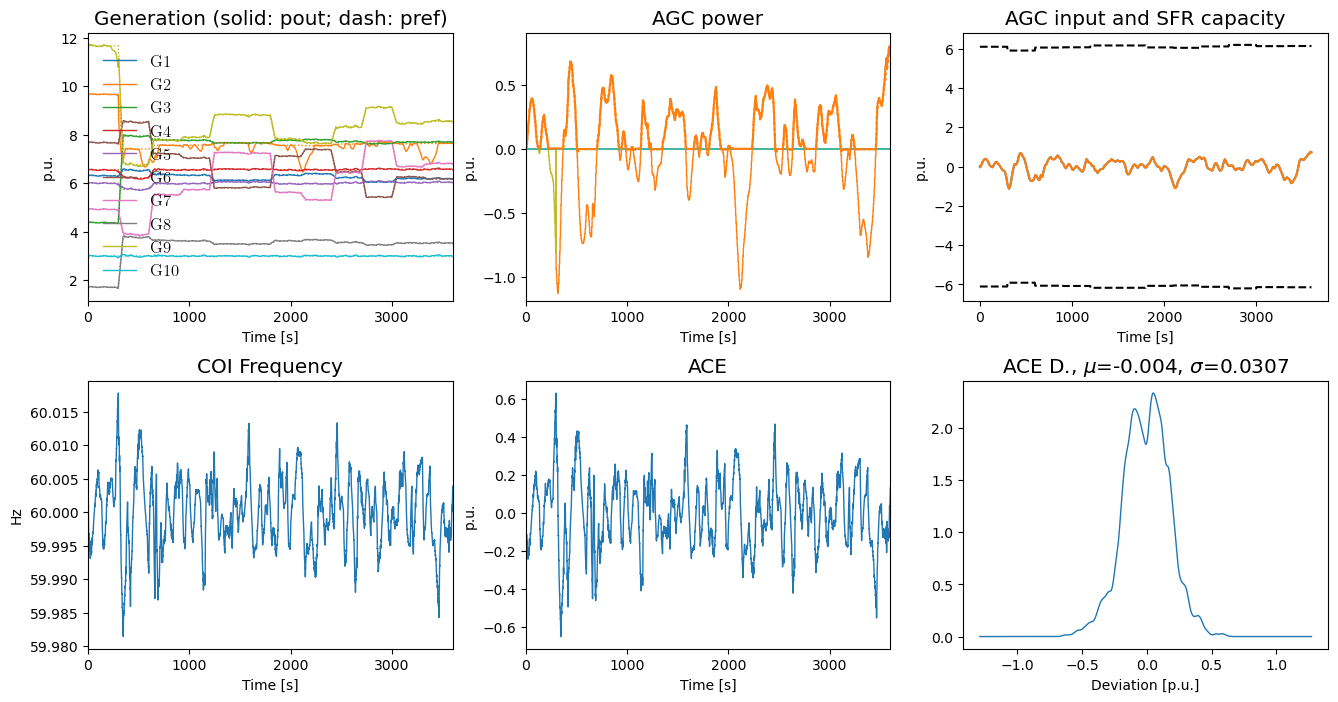

In [20]:
plt.style.use('default')

right = end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                 yheader=yheader,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                 linestyles=[':'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader,
                 legend=False, show=False, right=right,
                 title=r'AGC power',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 1])

# Plot EV AGC response, hard code
ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prl, color='tab:orange', linestyle=':')
ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='tab:orange', linestyle='-')
ax_gen[0, 1].set_ylim(top=max(sse.Prl) * 1.2)

sfr_res_plot = sfr_res.drop(['cat'], axis=1).T
sfr_res_plot.columns = sfr_res['cat'].values
ax_gen[0, 2].plot(sfr_res_plot.time, sfr_res_plot['ace'],
                  label='AGC raw')
ax_gen[0, 2].plot(sfr_res_plot.time, sfr_res_plot['in'],
                  label='AGC input')
ax_gen[0, 2].plot(sfr_res_plot.time, sfr_res_plot['up'],
                  label='SFR capacity',
                  linestyle='--', color='k')
ax_gen[0, 2].plot(sfr_res_plot.time, sfr_res_plot['dn'],
                  linestyle='--', color='k')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].set_xlabel('Time [s]')
ax_gen[0, 2].set_title('AGC input and SFR capacity')

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE D., $\mu$={ace_df.ace.mean().round(4)}, $\sigma$={ace_df.ace.var().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')


(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [H]', ylabel='Power (MW)'>)

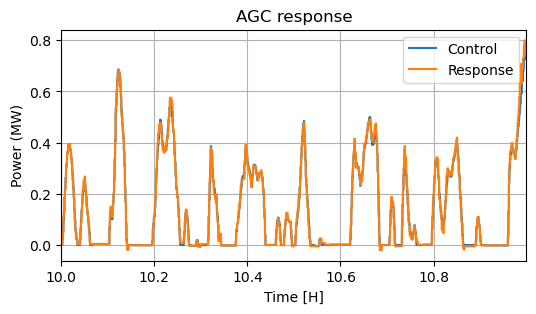

In [21]:
sse.plot_agc()

In [22]:
# Complement AGC table
agc_smooth = pd.DataFrame(np.repeat(agc_in[list(np.arange(0, t_total, 4))].values, 4, axis=1),
                       columns=list(np.arange(0, t_total, 1)))

# Record output
sse_out = pd.DataFrame()
sse_out['time'] = sse.tss
sse_out['agc'] = agc_smooth.iloc[10]  # AGC input to EV
sse_out['Pr'] = sse.Prl
sse_out['Prc'] = sse.Prcl
sse_out.to_csv('sse_out.csv', index=False)

(0.0, 3599.0)

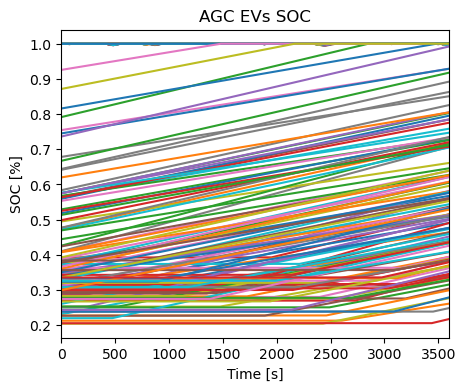

In [23]:
soc_plot = ev_soc[ev_agc.abs().sum(axis=1) > 0].reset_index(drop=True)
soc_plot = soc_plot[list(range(end_time+1))]

fig_soc, ax_soc = plt.subplots(figsize=(5, 4))
for i in range(soc_plot.shape[0]):
    ax_soc.plot(range(end_time+1), soc_plot.iloc[i])
ax_soc.set_xlabel('Time [s]')
ax_soc.set_ylabel('SOC [%]')
ax_soc.set_title('AGC EVs SOC')
ax_soc.set_xlim([0, end_time])

Text(0.5, 0, 'Time [s]')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


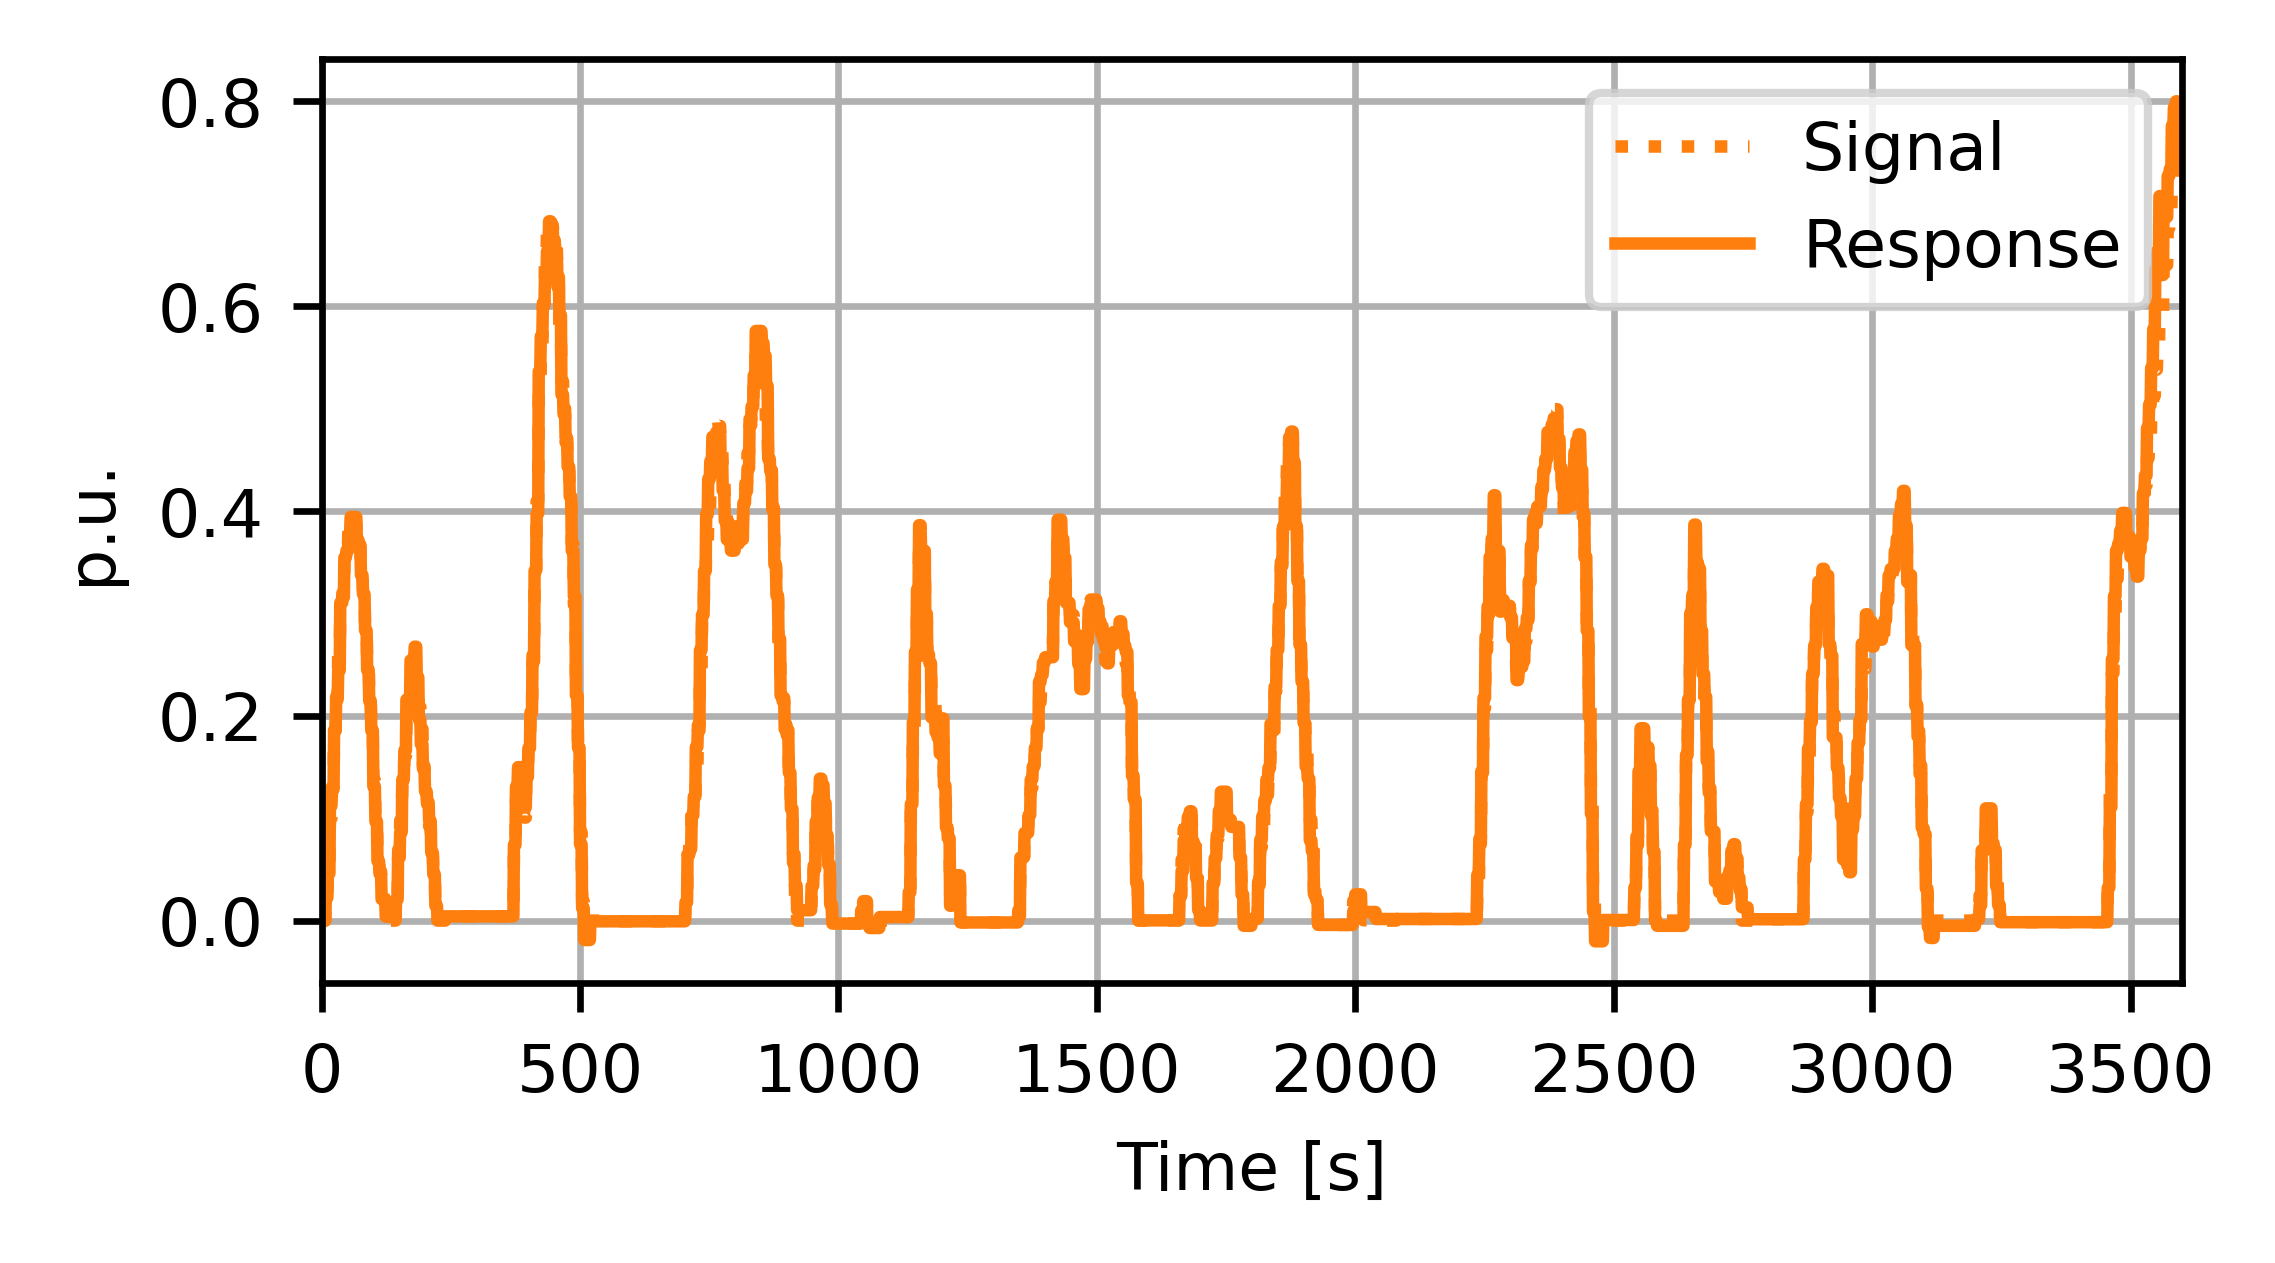

In [24]:
plt.style.use('ieee')
fige, axe = plt.subplots(figsize=(4, 2))
axe.plot(3600*(np.array(sse.tss)-10), sse.Prl, color='tab:orange', linestyle=':', label='Signal')
axe.plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='tab:orange', linestyle='-', label='Response')
axe.grid()
axe.legend()
axe.set_xlim(3600*(sse.tss[0]-10), 3600*(sse.tss[-1]-10))
axe.set_ylabel('p.u.')
axe.set_xlabel('Time [s]')

(<Figure size 3600x1800 with 2 Axes>,
 <AxesSubplot:title={'center':'EVA'}, xlabel='Time [H]', ylabel='Power (MW)'>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


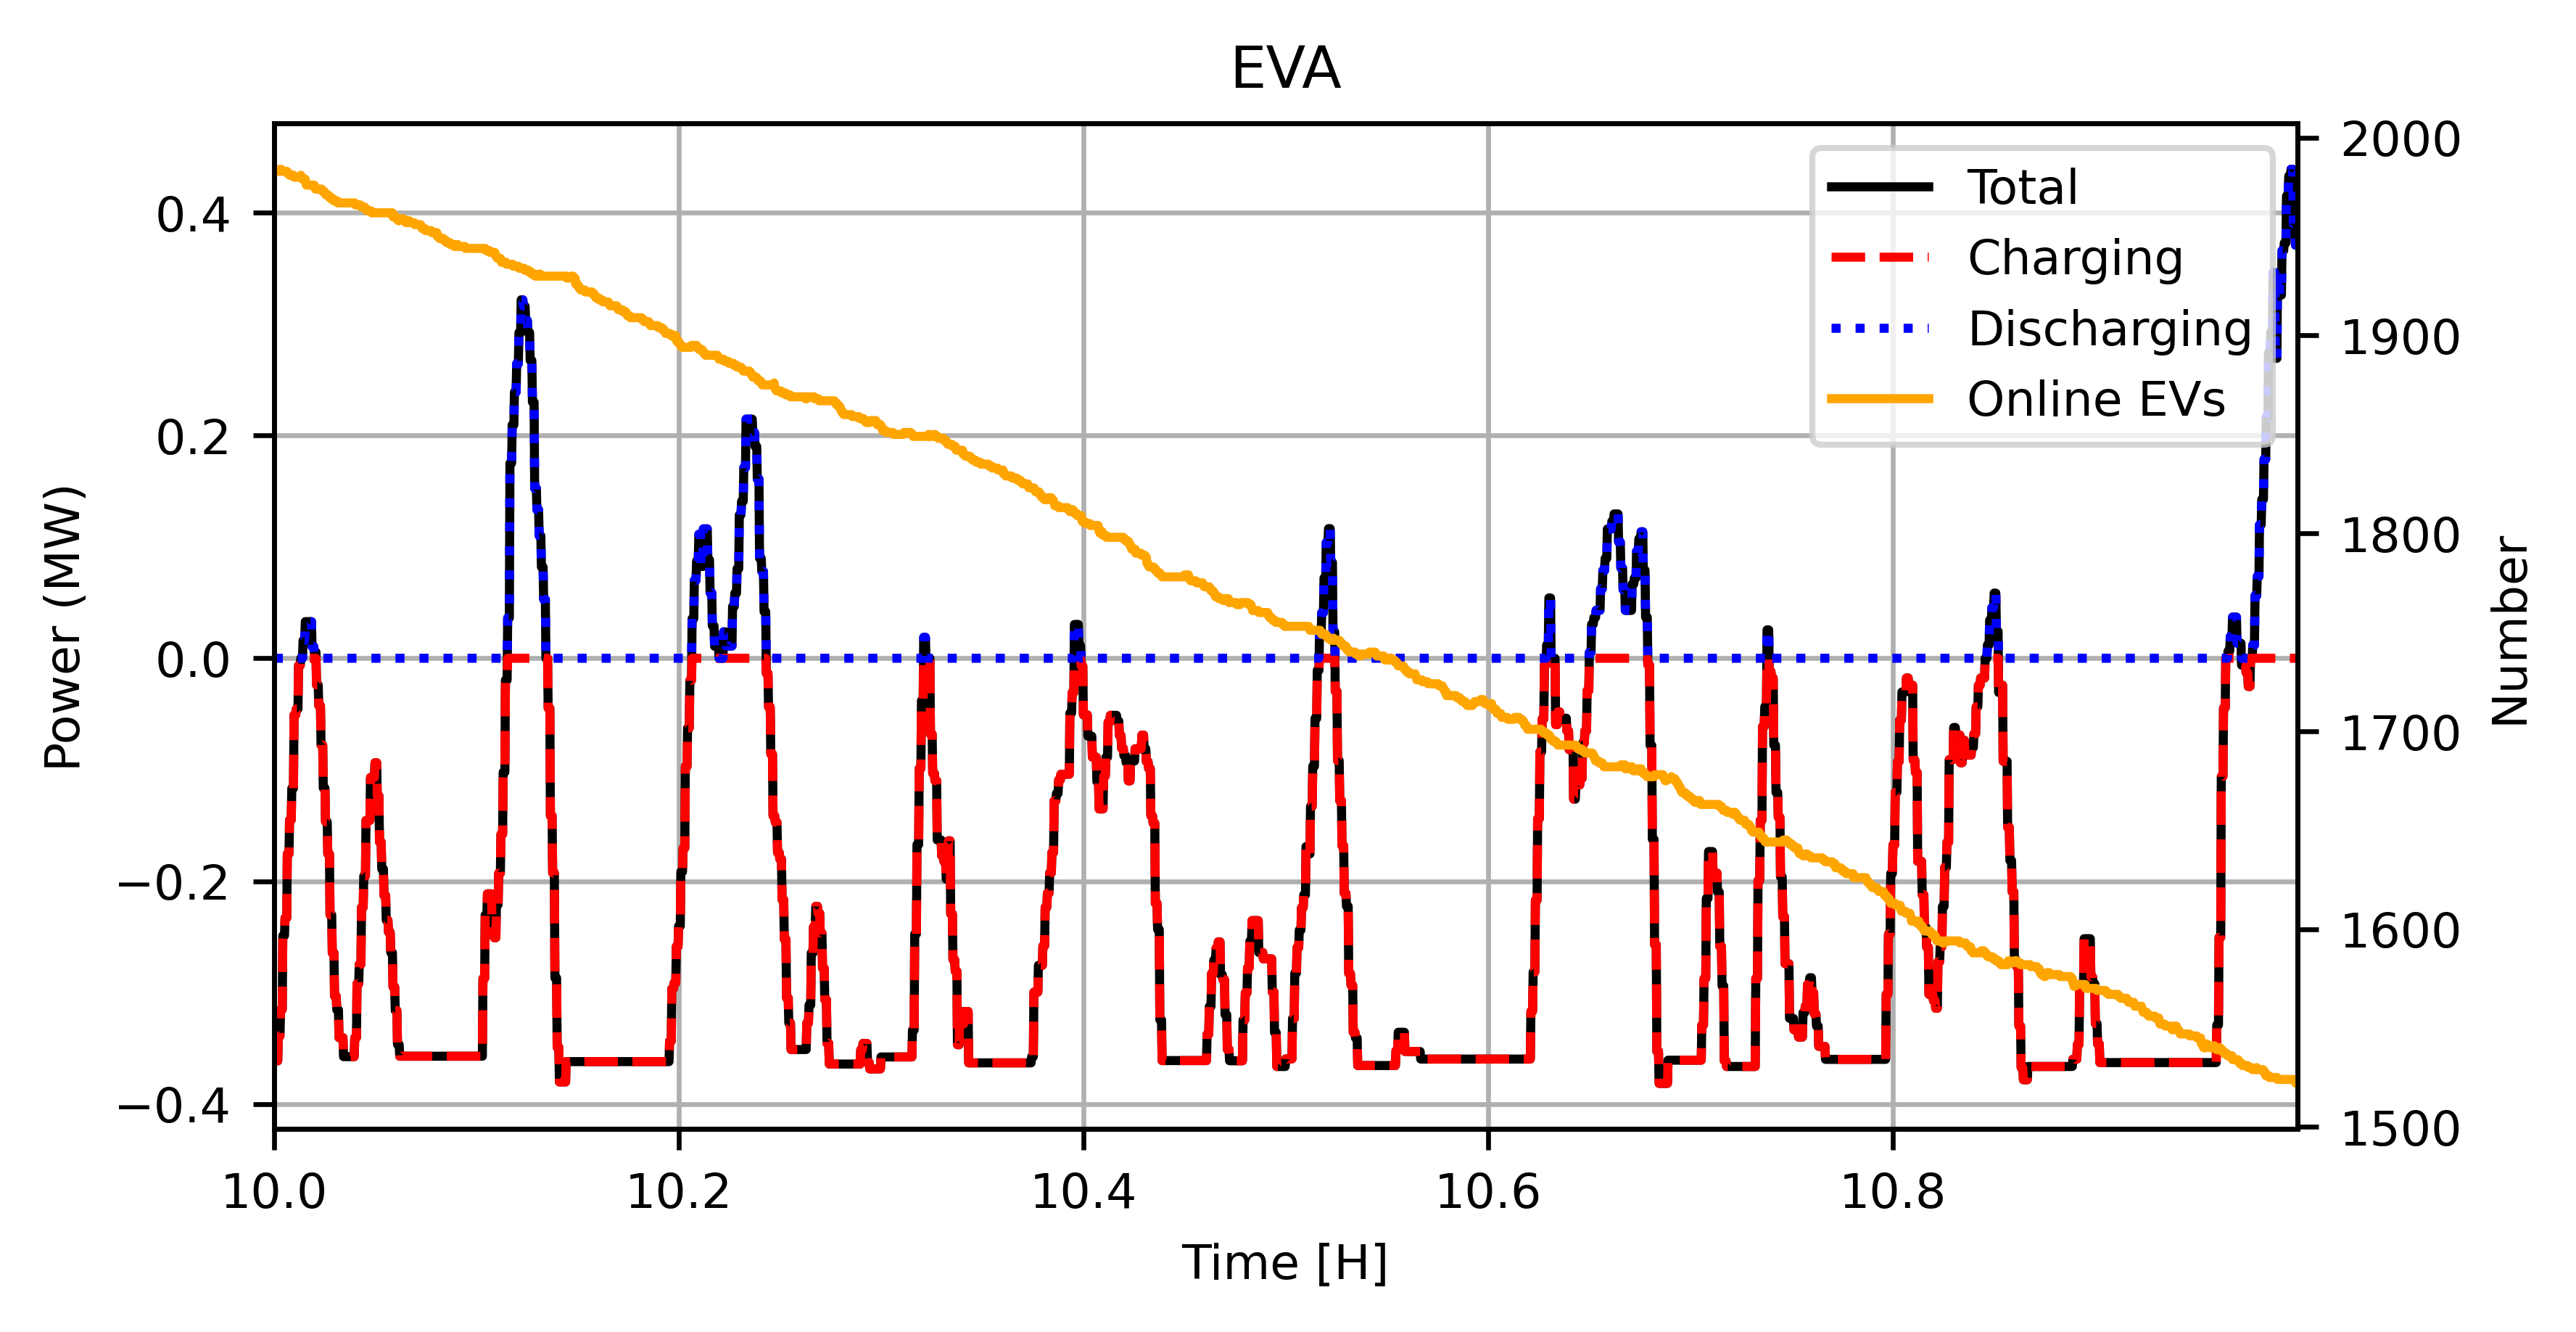

In [25]:
sse.plot(style='ieee')